# Random Forest

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import folium
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics import log_loss
from collections import Counter


from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalanceCascade
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = os.path.join(os.getcwd(), '14-4_accidents_vehicles7.csv')
df_clean = pd.read_csv(data_path, delimiter = ',', encoding='latin-1')
df_clean.drop(['Unnamed: 0'], axis=1, inplace=True)
df_clean

,Codi_barri,Descripcio_tipus_accident,Codi_carrer,Codi_districte,Descripcio_color,Descripcio_marca,Dia_setmana,Descripcio_causa_vianant,Descripcio_model,Descripcio_tipus_dia,...,Dissabte,Diumenge,Divendres,Laboral,Altres.2,Creuar per fora pas de vianants,Desobeir altres senyals,Desobeir el senyal del semÃ for,No Ã©s causa del vianant,Transitar a peu per la calÃ§ada
0,22,Col.lisiÃ³ lateral,202050,5,Blanc,AUDI,Dj,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0
1,20,Abast,700931,4,Gris,AUDI,Dv,No Ã©s causa del vianant,.A6,Laboral,...,0,0,1,1,0,0,0,0,1,0
2,20,Col.lisiÃ³ lateral,700931,4,Gris,AUDI,Dv,No Ã©s causa del vianant,.A6,Laboral,...,0,0,1,1,0,0,0,0,1,0
3,16,Col.lisiÃ³ fronto-lateral,701377,3,Negre,AUDI,Dc,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0
4,19,Col.lisiÃ³ fronto-lateral,320704,4,Gris,AUDI,Ds,No Ã©s causa del vianant,.A6,Laboral,...,1,0,0,1,0,0,0,0,1,0
5,12,Abast,701266,3,Negre,AUDI,Dl,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0
6,8,Col.lisiÃ³ lateral,144601,2,Gris,AUDI,Dj,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0
7,8,Abast multiple,245802,2,Gris,AUDI,Dl,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0
8,9,Col.lisiÃ³ fronto-lateral,361406,2,Gris,AUDI,Dv,No Ã©s causa del vianant,.A6,Laboral,...,0,0,1,1,0,0,0,0,1,0
9,8,Caiguda (dues rodes),32700,2,Gris,AUDI,Dm,No Ã©s causa del vianant,.A6,Laboral,...,0,0,0,1,0,0,0,0,1,0


In [3]:
df_clean2 = df_clean.copy()

# Labels are the values we want to predict
labels_y =  pd.get_dummies(df_clean2['Descripcio_model'])

# Remove the labels from the features
# axis 1 refers to the columns
features_X = df_clean2.drop(columns = ['Descripcio_color', 'Descripcio_marca', 
                                     'Descripcio_model','Descripcio_tipus_dia', 'NK_Any',
                                     'Descripcio_dia_setmana','Descripcio_tipus_vehicle',
                                     'Num_portes_laterals','Tipus_cotxe','Dia_setmana',
                                     'Descripcio_causa_vianant','Descripcio_tipus_accident'], axis = 1)
# Saving feature names for later use
feature_list = list(features_X.columns)


num_columns = len(features_X.columns)
pd.set_option("display.max_columns", num_columns)
features_X

,Codi_barri,Codi_carrer,Codi_districte,Antiguitat_carnet,Dia_mes,Hora_dia,Mes_any,Latitud,Longitud,Altres,Beige,Blanc,Blau,Daurat,Gris,Groc,MarrÃ³,Negre,Negre/Groc,Platejat,Rosa,Taronja,Verd,Vermell,Violeta,granate,ALFA ROMEO,AUDI,BMW,CHEVROLET,CHRYSLER,CITROEN,DACIA,DAEWOO,FIAT,FORD,HONDA,HYUNDAI,KIA,LANCIA,LAND ROVER,LEXUS,MAZDA,MERCEDES,MINI,MITSUBISHI,NISSAN,OPEL,PEUGEOT,RENAULT,ROVER,SAAB,SEAT,SKODA,SMART,SUBARU,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO,Turisme,2016,2017,2018,Abast,Abast multiple,Altres.1,Atropellament,Bolcada (mÃ©s de dues rodes),Caiguda (dues rodes),Caiguda interior vehicle,Col.lisiÃ³ frontal,Col.lisiÃ³ fronto-lateral,Col.lisiÃ³ lateral,EncalÃ§,Resta sortides de via,Sortida de via amb bolcada,Sortida de via amb xoc o col.lisiÃ³,Xoc contra element estÃ tic,2,3,4,4x4/SUV,antic/classic,compact,esportiu,familiar,furgoneta,micro,sedan,Dijous,Dilluns,Dimarts,Dimecres,Dissabte,Diumenge,Divendres,Laboral,Altres.2,Creuar per fora pas de vianants,Desobeir altres senyals,Desobeir el senyal del semÃ for,No Ã©s causa del vianant,Transitar a peu per la calÃ§ada
0,22,202050,5,12,10,19,11,41.424889,2.092323,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,700931,4,20,20,10,5,41.381229,2.118918,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,20,700931,4,20,20,10,5,41.381229,2.118918,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
3,16,701377,3,42,21,12,9,41.365692,2.134540,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,19,320704,4,6,18,3,6,41.390549,2.142440,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
5,12,701266,3,19,11,12,7,41.349507,2.146827,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
6,8,144601,2,0,24,17,3,41.393346,2.147905,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,8,245802,2,17,4,11,1,41.392053,2.150960,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
8,9,361406,2,46,21,14,10,41.380578,2.155881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0
9,8,32700,2,49,25,12,10,41.393404,2.157019,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_X, 
                                                    labels_y, 
                                                    train_size=0.75, 
                                                    random_state = 0)

In [5]:
print('Number of instances in X: {}'.format(np.shape(features_X)[0]))

print('\nNumber of instances in X_train: {}'.format(X_train.shape))
print('Number of instances in y_train: {}'.format(y_train.shape))
print('Number of instances in X_test: {}'.format(X_test.shape))
print('Number of instances in y_test: {}'.format(y_test.shape))


Number of instances in X: 18150

Number of instances in X_train: (13612, 104)
Number of instances in y_train: (13612, 194)
Number of instances in X_test: (4538, 104)
Number of instances in y_test: (4538, 194)


In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

In [7]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver ='full')  
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)

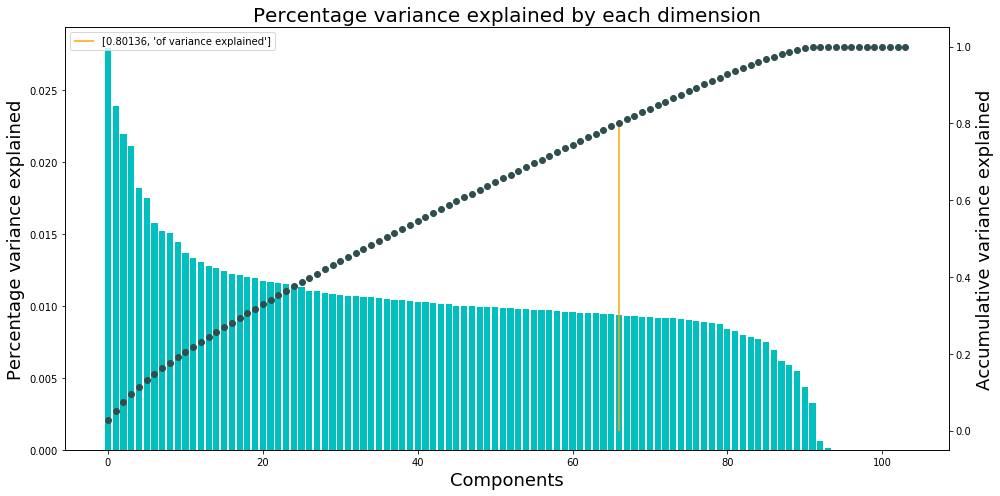

In [8]:
ac_var = 0
x = 0
bar = True

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.xlabel('Components',fontsize=18)
plt.ylabel('Percentage variance explained', fontsize=18)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(ac_var)  # we already handled the x-label with ax1
plt.ylabel('Accumulative variance explained', fontsize=18)

while x < X_train_pca.shape[1]:
    ax1.tick_params(axis='y')
    ax1.bar(x, pca.explained_variance_ratio_[x], width=0.8, color="c") #Eigenvalues
    ac_var = pca.explained_variance_ratio_[x] + ac_var
    ax2.plot(x, ac_var, linestyle='-', marker='o',color="darkslategray")
    if ac_var > 0.8 and bar == True:
        plt.vlines(x, 0, ac_var, colors="orange", linestyles='solid', label = [round(ac_var,5),'of variance explained'] )
        bar = False
    x = x + 1

plt.title('Percentage variance explained by each dimension',fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In some dataset all the features are contributing equally to the overall variance, therefore all the principal components are crucial to the predictions and none can be ignored.

In [33]:
param_grid = { 
    'n_estimators': [150],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 30, 50],
#     'criterion' :['gini', 'entropy']
} 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Random forest
clf_rf = RandomForestClassifier(criterion='gini',
                                random_state=0)

clf_rf_grid = GridSearchCV(clf_rf, param_grid, cv=3, n_jobs=-1)

# Train model
model = clf_rf_grid.fit(X_train, y_train)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test,clf_rf_grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        17
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00        10
           6       0.82      1.00      0.90         9
           7       1.00      0.10      0.18        10
           8       0.85      0.19      0.31        58
           9       1.00      0.07      0.13        43
          10       0.67      0.18      0.29        22
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         8
          13       1.00      0.31      0.47        13
          14       1.00      1.00      1.00        13
          15       1.00      0.07      0.12        61
          16       0.76      0.38      0.51        42
          17       1.00    

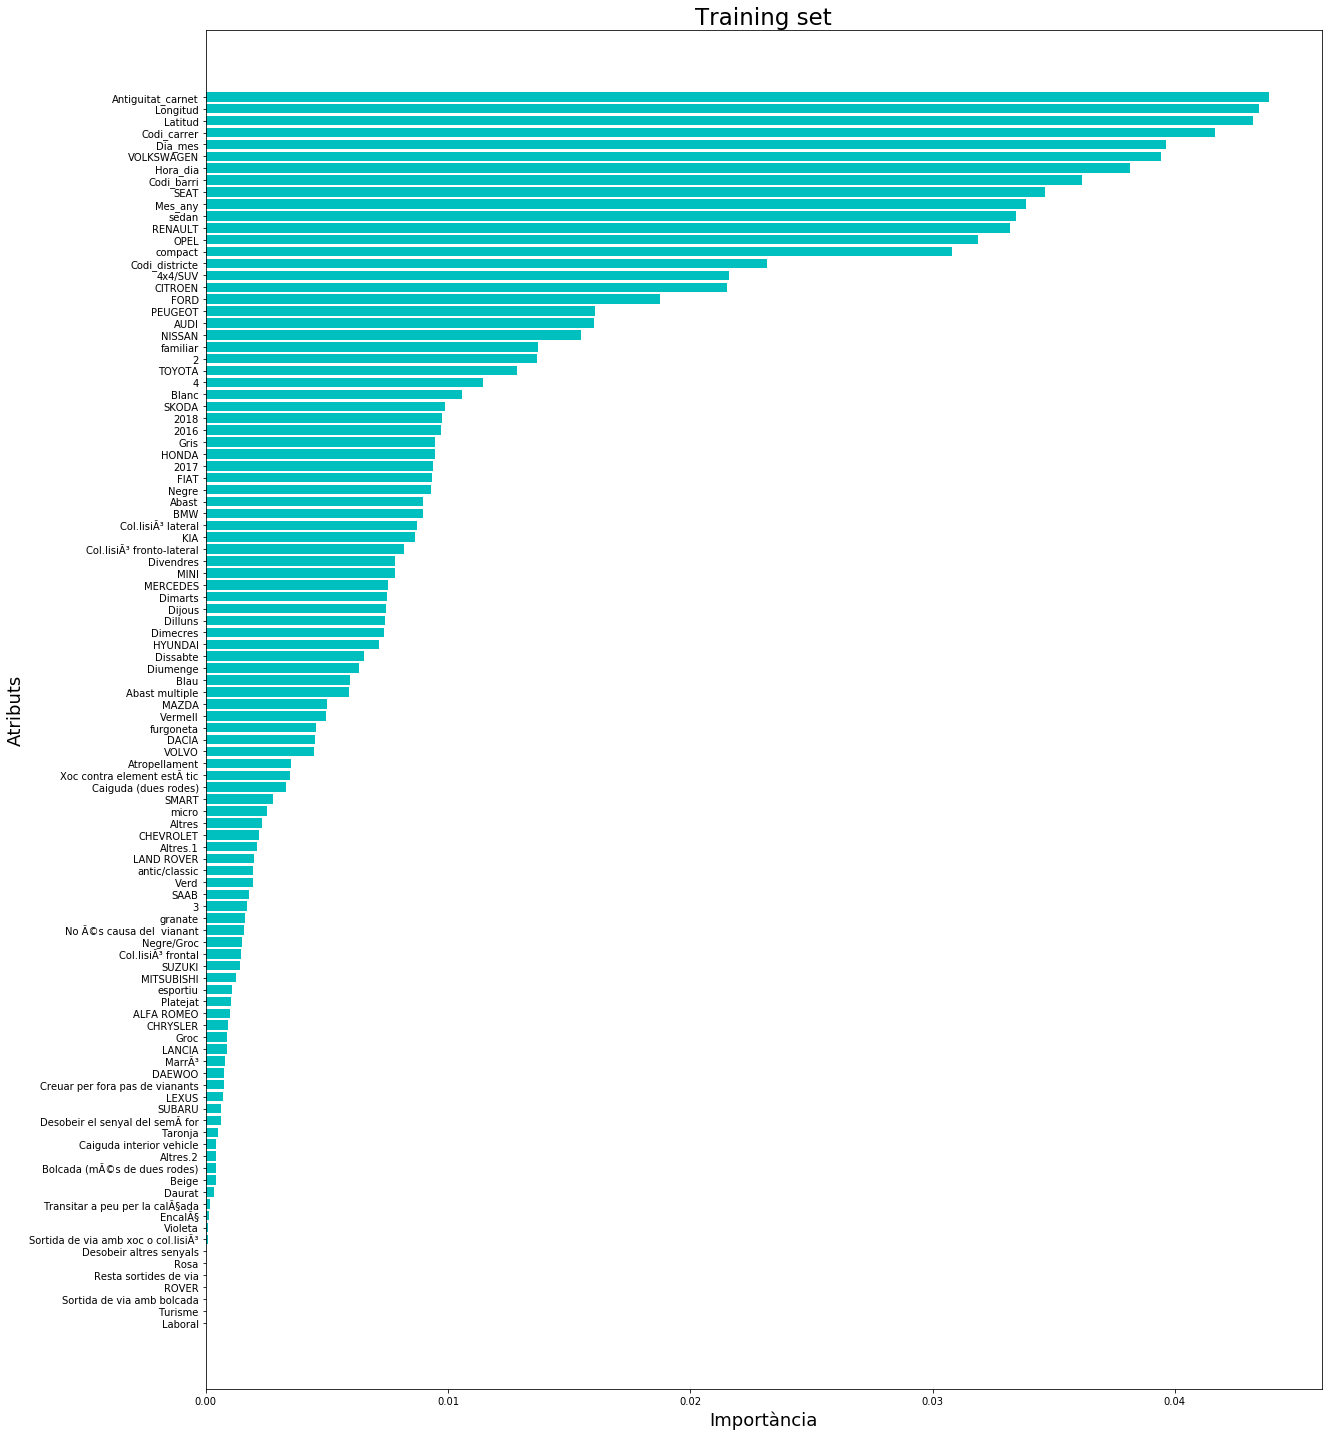

In [37]:
imp = clf_rf_grid.best_estimator_.feature_importances_
names = features_X.columns

imp, names = zip(*sorted(zip(imp, names)))

fig = plt.figure(figsize=(20,25))
ax = fig.gca()

plt.barh(range(len(names)),imp, align = 'center', color='c')
plt.yticks(range(len(names)), names)

ax.set_ylabel('Atributs', size = 18)
ax.set_xlabel('Importància', size = 18)
ax.set_title('Training set', size = 23)

plt.show()

The cost-sensitive approach would be to assign different weights to different classes. So if the minority class is assigned a higher weight and thus higher misclassification cost, then that can help reduce its biasness towards the majority class. You can use the class weight parameter of random forest in scikit-learn to assign weights to each class.

In [38]:
y_pred = clf_rf_grid.predict(X_train) 
y_test_pred = clf_rf_grid.predict(X_test)

In [39]:
print('Classification accuracy on training set: {:.5f}'.format(accuracy_score(y_train,y_pred)))
print('Log Loss on training set: {:.5f}'.format(log_loss(y_train,y_pred)))

print('\nClassification accuracy on test set: {:.5f}'.format(accuracy_score(y_test,y_test_pred))) 
print('Log Loss on test set: {:.5f}'.format(log_loss(y_test,y_test_pred))) 

Classification accuracy on training set: 0.99985
Log Loss on training set: 0.00077

Classification accuracy on test set: 0.49846
Log Loss on test set: 6.82822


In [40]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier().fit(X_train, y_train) 
pred_y_d = dummy_classifier.predict(X_test)
print('Dummy Classifier accuracy on the test set: {:.5f}'.format(accuracy_score(y_test,pred_y_d)))
print('Log Loss of the Dummy Classifier: {:.5f}'.format(log_loss(y_test,pred_y_d))) 

Dummy Classifier accuracy on the test set: 0.00419
Log Loss of the Dummy Classifier: 23.34902


In [41]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    fig = plt.figure(figsize=(10,7))
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title, size=18)
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    plt.show()

<Figure size 432x288 with 0 Axes>

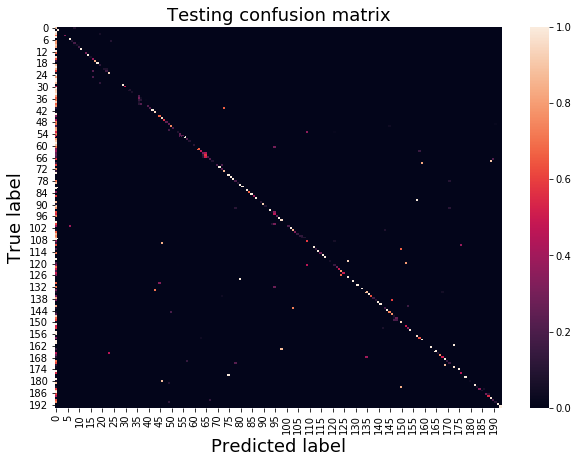

In [42]:
cm = confusion_matrix(y_test.values.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, title='Testing confusion matrix')